# Amazon forest analysis from satellite images.


Data obtained from the kaggle competition https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/

## Visualize whats happening in the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# base_path = '/media/anant/data/amazon_from_space/'
base_path = '/media/avemuri/DEV/Data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### Plot the frequency of each label

In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'habitation', 'primary', 'bare_ground', 'artisinal_mine', 'selective_logging', 'partly_cloudy', 'conventional_mine', 'clear', 'blooming', 'agriculture', 'blow_down', 'slash_burn', 'water', 'cloudy', 'cultivation', 'road', 'haze'}


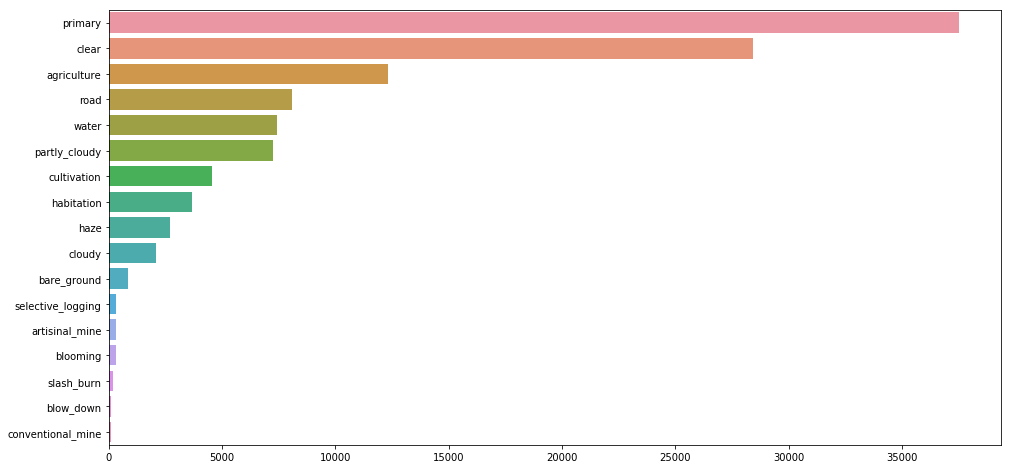

In [5]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Imports for training

In [6]:
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models

from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Accuracy, Precision, Recall, Loss, Metric

## Get data

### Get data as numpy array

In [7]:
def get_data(base_path=base_path, folder_name='train-jpg', csv_file='train_v2.csv'):
    
    X = []
    y = []
    df_train = pd.read_csv(base_path+csv_file)

    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in tqdm(df_train.values, miniters=1000):
        img = cv2.imread(base_path+folder_name+'/'+'{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 
        X.append(cv2.resize(img, (32, 32)))
        #y.append(targets)
    
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df_train['tags'].str.split()).astype(np.float32)
    
    # y = np.array(y, np.uint8)
    X = np.array(X, np.float16) / 255.
                         
    return X, y

In [8]:
X, y = get_data()

100%|██████████| 40479/40479 [00:39<00:00, 1028.22it/s]


In [9]:
X = np.moveaxis(X, (0,1,2,3), (0,2,3,1))
print(X.shape, y.shape)

(40479, 3, 32, 32) (40479, 17)


In [10]:
SPLIT = 0.2
dataset_size = X.shape[0]
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

x_train, y_train = X[train_indices], y[train_indices]
x_valid, y_valid = X[val_indices], y[val_indices]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(32384, 3, 32, 32) (32384, 17) (8095, 3, 32, 32) (8095, 17)


In [11]:
BATCH_SIZE = 256
train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
valid_dataset = TensorDataset(torch.from_numpy(x_valid).float(), torch.from_numpy(y_valid).float())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=8, 
                          pin_memory=True)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=8, 
                          pin_memory=True)

In [12]:
for i in range(4):
    x, y = next(iter(train_loader))
    print(x.shape, y.shape)
    x, y = next(iter(valid_loader))
    print(x.shape, y.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])


### Get data from pytorch dataset object

In [7]:
df_train = pd.read_csv(base_path+'train_v2.csv')

In [8]:
class AmazonDataset(Dataset):
    def __init__(self, base_folder, csv_file, folder_name, select_indices=None, transform=None):
        self.csv_file = csv_file
        self.labels_df = pd.read_csv(base_path+csv_file)
        self.base_folder = base_folder
        self.image_list = [f for f in glob.glob(base_path+folder_name+'/*.jpg')]
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.labels = self.mlb.fit_transform(self.labels_df['tags'].str.split()).astype(np.float32)
        
        if select_indices is not None:
            self.labels_df = self.labels_df.loc[select_indices]
            self.image_list = list(np.array(self.image_list)[select_indices])
        
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index])
        image = image.convert('RGB')
        # image = cv2.imread(self.image_list[index])
        
        label = torch.from_numpy(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SHUFFLE = True
SPLIT = 0.2

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_transform_augmented = transforms.Compose([transforms.Resize(IMG_SIZE),
                                                #transforms.ColorJitter(brightness=0.5),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor(),
                                                normalize])
valid_transform_augmented = transforms.Compose([transforms.Resize(IMG_SIZE),
                                                transforms.ToTensor(), 
                                                normalize])

In [11]:
image_list = [f for f in glob.glob(base_path+'train-jpg'+'/*.jpg')]
SPLIT = 0.2
dataset_size = len(image_list)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_dataset = AmazonDataset(base_path, 'train_v2.csv', 'train-jpg', 
                              select_indices=train_indices,
                              transform=train_transform_augmented)
valid_dataset = AmazonDataset(base_path, 'train_v2.csv', 'train-jpg', 
                              select_indices=val_indices,
                              transform=valid_transform_augmented)

print(len(train_indices), len(val_indices), len(train_dataset), len(valid_dataset))

32384 8095 32384 8095


In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=SHUFFLE)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=SHUFFLE)
print(len(train_loader), len(valid_loader))

506 127


In [13]:
for i in range(4):
    x, y = next(iter(train_loader))
    print(x.shape, y.shape)
    

torch.Size([64, 3, 224, 224]) torch.Size([64, 17])
torch.Size([64, 3, 224, 224]) torch.Size([64, 17])
torch.Size([64, 3, 224, 224]) torch.Size([64, 17])
torch.Size([64, 3, 224, 224]) torch.Size([64, 17])


## Model definition

### Basic model

In [46]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv13 = nn.Conv2d(32, 32, kernel_size=3)
        
        self.conv21 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv23 = nn.Conv2d(64, 64, kernel_size=3)
        
        self.conv2_drop_1 = nn.Dropout2d(0.25)
        self.conv2_drop_2 = nn.Dropout2d(0.25)
        self.linear_drop = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(576, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 17)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.conv2_drop_1(F.max_pool2d(F.relu(self.conv13(x)), (2,2)))
        
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.conv2_drop_2(F.max_pool2d(F.relu(self.conv23(x)), (2,2)))
                
        x = x.view(x.size(0), -1) # Flatten layer
                        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.linear_drop(x)
        x = self.fc4(x)
        
        return torch.sigmoid(x)

In [47]:
img = torch.from_numpy(np.random.randn(3,3,32,32)).float()
print(img.shape)
model = BaseNet()
out = model(img)
print(out.shape)

torch.Size([3, 3, 32, 32])
torch.Size([3, 17])


### Advanced model

In [14]:
class AdvancedNet(nn.Module):
    def __init__(self):
        super(AdvancedNet, self).__init__()
        
        pretrained_model = models.resnet34(pretrained=True)
        self.pretrained_model = nn.Sequential(*list(pretrained_model.children())[0:9])
        for parameter in self.pretrained_model.parameters():
            parameter.requires_grad = False
            
        self.additional_stacked_layers = nn.Sequential(nn.Linear(512, 512),
                                                       nn.ReLU(inplace=True),
                                                       nn.Dropout2d(0.5),
                                                       nn.Linear(512, 256),
                                                       nn.ReLU(inplace=True),
                                                       nn.Linear(256, 128),
                                                       nn.ReLU(inplace=True),
                                                       nn.Dropout2d(0.5),
                                                       nn.Linear(128, 17))
        
#         self.classifier = nn.Sequential(self.pretrained_model,
#                                         self.additional_stacked_layers)
        

    def forward(self, x):
        x = self.pretrained_model(x)
        x = x.view(x.size(0), -1) # Flatten layer
        x = self.additional_stacked_layers(x)
        
        return torch.sigmoid(x)

In [15]:
img = torch.from_numpy(np.random.randn(3,3,224,224)).float()
print(img.shape)
model = AdvancedNet()
out = model(img)
print(out.shape)

torch.Size([3, 3, 224, 224])
torch.Size([3, 17])


## Metrics

In [16]:
class KerasMetrics:
	def precision(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		predicted_positives = k.backend.sum(k.backend.round(k.backend.clip(y_pred, 0, 1)))
		precision = true_positives / (predicted_positives + k.backend.epsilon())
		return precision

	def recall(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		possible_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1)))
		recall = true_positives / (possible_positives + k.backend.epsilon())
		return recall

	def fbeta_score(self, y_true, y_pred, beta=2):
		if beta < 0:
			raise ValueError('The lowest choosable beta is zero (only precision).')

		if k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1))) == 0:
			return 0

		p = self.precision(y_true, y_pred)
		r = self.recall(y_true, y_pred)
		bb = beta ** 2
		fbeta_score = (1 + bb) * (p * r) / (bb * p + r + k.backend.epsilon())
		return fbeta_score

In [17]:
class FBetaScore(Metric):
    """
    Calculate the fbeta score.

    - `update` must receive output of the form `(y_pred, y)`.
    """
    def __init__(self, beta=2, output_transform=lambda x: x):
        self.precision = Precision(average=True)
        self.recall = Recall(average=True)
        
        super(FBetaScore, self).__init__(output_transform)
        self.beta = beta
        

    def reset(self):
        self.precision.reset()
        self.recall.reset()

    def update(self, output):
        
        self.precision.update(output)
        self.recall.update(output)

    def compute(self):
#         if self._num_examples == 0:
#             raise NotComputableError('FBetaScore must have at least one example before it can be computed')
        p = self.precision.compute()
        r = self.recall.compute()
        bb = self.beta ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + 1e-07) 
        return fbeta_score

In [18]:
# keras_metrics = KerasMetrics() 

## Training

### Train - from data as numpy array and simple model

In [19]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [20]:
model = BaseNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = create_supervised_trainer(model, optimizer, F.binary_cross_entropy, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'accuracy': Accuracy(), 
                                                                       'loss': Loss(F.binary_cross_entropy),
                                                                       'recall': Recall(),
                                                                       'precision': Precision(),
                                                                       'fbeta': FBetaScore()}) 

NameError: name 'BaseNet' is not defined

In [21]:
# @trainer.on(Events.EPOCH_COMPLETED)
# def log_training_loss(trainer):
#     epoch = trainer.state.epoch
#     #iteration = engine.state.iteration
#     loss = trainer.state.output
#     print("Epoch: {0} Loss: {1}".format(epoch, loss)) 
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    loss = trainer.state.output
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    
#     print("Training Results - Epoch: {0}  Training loss: {2}"
#           .format(trainer.state.epoch,
#                   loss))
    print("Training Results - Epoch: {}  Training loss: {:.2f} Avg accuracy: {:.2f} Avg loss: {:.2f}  Avg Recall: {:.2f}  Avg Precision: {:.2f}  Avg fbeta: {:.2f}"
          .format(trainer.state.epoch,
                  loss,
                  metrics['accuracy'], 
                  metrics['loss'],
                  metrics['recall'],
                  metrics['precision'],
                  metrics['fbeta']))
    
@trainer.on(Events.EPOCH_COMPLETED)
def run_evaluator_on_validation_data(engine):
    evaluator.run(valid_loader)
    
@trainer.on(Events.EPOCH_COMPLETED)
def run_trainer_on_training_data(engine):
    evaluator.run(train_loader)
    #print("Epoch: {0} Loss: {1}".format(epoch, loss)) 

NameError: name 'trainer' is not defined

In [57]:
trainer.run(train_loader, max_epochs=50)

Training Results - Epoch: 1  Training loss: 0.30 Avg accuracy: 0.90 Avg loss: 0.27  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 2  Training loss: 0.27 Avg accuracy: 0.90 Avg loss: 0.25  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 3  Training loss: 0.27 Avg accuracy: 0.90 Avg loss: 0.24  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 4  Training loss: 0.25 Avg accuracy: 0.90 Avg loss: 0.24  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 5  Training loss: 0.25 Avg accuracy: 0.90 Avg loss: 0.24  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 6  Training loss: 0.25 Avg accuracy: 0.90 Avg loss: 0.24  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 7  Training loss: 0.25 Avg accuracy: 0.90 Avg loss: 0.24  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 8

### Train - using data from pytorch dataloader and advanced model

In [22]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [23]:
model = AdvancedNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = create_supervised_trainer(model, optimizer, F.binary_cross_entropy, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'accuracy': Accuracy(), 
                                                                       'loss': Loss(F.binary_cross_entropy),
                                                                       'recall': Recall(),
                                                                       'precision': Precision(),
                                                                       'fbeta': FBetaScore()}) 

In [24]:
# @trainer.on(Events.EPOCH_COMPLETED)
# def log_training_loss(trainer):
#     epoch = trainer.state.epoch
#     #iteration = engine.state.iteration
#     loss = trainer.state.output
#     print("Epoch: {0} Loss: {1}".format(epoch, loss)) 
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    loss = trainer.state.output
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    
#     print("Training Results - Epoch: {0}  Training loss: {2}"
#           .format(trainer.state.epoch,
#                   loss))
    print("Training Results - Epoch: {}  Training loss: {:.2f} Avg accuracy: {:.2f} Avg loss: {:.2f}  Avg Recall: {:.2f}  Avg Precision: {:.2f}  Avg fbeta: {:.2f}"
          .format(trainer.state.epoch,
                  loss,
                  metrics['accuracy'], 
                  metrics['loss'],
                  metrics['recall'],
                  metrics['precision'],
                  metrics['fbeta']))
    
@trainer.on(Events.EPOCH_COMPLETED)
def run_evaluator_on_validation_data(engine):
    evaluator.run(valid_loader)
    
@trainer.on(Events.EPOCH_COMPLETED)
def run_trainer_on_training_data(engine):
    evaluator.run(train_loader)
    #print("Epoch: {0} Loss: {1}".format(epoch, loss)) 

In [ ]:
trainer.run(train_loader, max_epochs=50)

Training Results - Epoch: 1  Training loss: 0.29 Avg accuracy: 0.91 Avg loss: 0.26  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 2  Training loss: 0.28 Avg accuracy: 0.91 Avg loss: 0.26  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
Training Results - Epoch: 3  Training loss: 0.26 Avg accuracy: 0.91 Avg loss: 0.26  Avg Recall: 0.57  Avg Precision: 0.81  Avg fbeta: 0.60
